In [1]:
import numpy as np
import pandas as pd
import csv
import math
from sklearn.model_selection import train_test_split
import random
from collections import Counter
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
def calculateInitialGinni(training_set):
    training_set=np.asarray(training_set).astype("float")
    initial_ginni = ginni(training_set)
    return initial_ginni

In [4]:
def calculateIG(parentGinni, currentGinni):
    return (parentGinni-currentGinni)

In [5]:
def ginni(training_set):
    if(training_set.shape[0]==0):
        return 0
    training_set1=training_set[:,-1]
    unique_elements, counts_elements = np.unique(training_set1, return_counts=True) # get the count and type of label in the rows
    dic=dict(zip(unique_elements,counts_elements)) # create a dictionary with the label and count 
    p = []
    for label in dic:
        p.append(dic[label]/float(training_set1.shape[0])) # get the probability of every label into an array so that it is easy for numpy calculation
    return 1-np.sum(np.multiply(p,p))

In [6]:
def ginniVal(training_set, column_index, value):
    training_set_left = [row for row in training_set if float(row[column_index]) >= value]
    training_set_right = [row for row in training_set if float(row[column_index])< value]
    training_set_left = np.asarray(training_set_left,dtype='float')
    training_set_right = np.asarray(training_set_right,dtype='float')
    p =float((training_set_left.shape[0])/(training_set_left.shape[0]+training_set_right.shape[0]))
    return p*ginni(training_set_left)+(1-p)*ginni(training_set_right)

In [7]:
def findSplit(training_set,featureList):
    local_ginni=0
    local_column=None
    best_ginni=1
    best_column=0
    col_mean_final=0
    bestIg=0
    parentGinni=calculateInitialGinni(training_set)
    
    for col in featureList:
        col_data= [float(row[col]) for row in training_set]
#         print("Column data for ",col, " is :",col_data)
        col_mean=float(np.sum(col_data)/len(col_data)) # get col_mean for the remaining rows
        true_rows, false_rows= partition(training_set,col,col_mean)
        if(len(true_rows) == 0 or len(false_rows)==0):
            continue
        local_ginni= ginniVal(training_set,col,col_mean)
        localIg= calculateIG(parentGinni,local_ginni)
        if localIg>= bestIg:
            bestIg=localIg
            best_ginni=local_ginni
            best_column = col
            col_mean_final=col_mean
    return  bestIg,best_column,col_mean_final

In [8]:
def partition(training_set, column_index, value):
    true_rows= [row for row in training_set if float(row[column_index]) >= value]
    false_rows = [row for row in training_set if float(row[column_index])< value]
    return true_rows, false_rows

In [9]:
# get the class of data in case it cant be split further i.e all the data in this particular class belong to
# the same class. So we just take the first label and set it as the output label for the decision tree node
def getClass(training_set, column_index,value):
    true_label= None
    false_label=None
    true_rows= [row for row in training_set if float(row[column_index]) >= value]
    false_rows = [row for row in training_set if float(row[column_index])< value]
    
    if len(true_rows)>0:
#         true_rows=np.asarray(true_rows)
        true_label = true_rows[0][-1]
    if len(false_rows)>0:
        false_label= false_rows[0][-1]
        
    if false_label==1:
        false_label="class1"
    if true_label==0:
        true_label="class0"
    if false_label==0:
        false_label="class0"
    if true_label==1:
        true_label="class1"
    if len(true_rows)> len(false_rows):
        return true_label
    else:
        return false_label
#     return true_label, false_label

In [10]:
class DecisionTree():
    def __init__(self):
        self.tree = {}
    def learn(self, training_set,index,featureList,features):
        #implement this function
        value=0
        true_index=0
        false_index=0
        random_feature_list= random.sample(featureList,features)
        gain,column_name,value = findSplit(training_set,random_feature_list)
#         print("Value is::",value,"for column ::",column_name)
        #check terminating criteria with gini= 0 which means it is evenly being split
        if gain==0:
            return getClass(training_set, column_name, value)
        true_rows, false_rows = partition(training_set,column_name,value)
        
        # Make the recursive call for both true and false rows and get the index
        true_index = self.learn(true_rows, 2*index,featureList,features)
        
        false_index= self.learn(false_rows,2*index+1,featureList,features)
        
        #use the index the insert the data required into the tree
       
        self.tree[index]=[column_name,value,{"true_rows":true_index,"false_rows":false_index}]
        return index
    

    def classify(self, test_instance):
#         print(self.tree)
        result = 0 # baseline: always classifies as 0
        index=1 # root index
        while 1:
            value= self.tree[index]
            column_num= value[0]
            values=value[1]
            if float(test_instance[column_num])>=float(values):
                result= value[2]["true_rows"] # the third item in the tree is a dictionary that contains both the T and F ids
            else:
                result=value[2]["false_rows"]
            if result=="class1" or result=="class0":
                break
            else:
                index=result
        if result=="class1":
            result="1"
        else:
            result="0"
        return result

In [11]:
def reduceDataset(train,no_Elements):
    # reduce the count of dataset to no_Elements
    train= train.sample(n=no_Elements)
    random_dataset= train.values
    random_subset = train.iloc[:, :-1]
    featureList=[i for i in range(random_subset.shape[1])]
    #selected_features = random.sample(featureList,features)
    train=train.values
    return train,featureList

In [12]:
def buildForest(train, features, count_trees, no_Elements):
    forest=[]
    for i in range(count_trees):
        dataset,featureList= reduceDataset(train,no_Elements)
#         featureList.sort()
        train_dataset=dataset.tolist()
        tree = DecisionTree()
        tree.learn( train_dataset,1,featureList,features)
        forest.append(tree)
    return forest

In [13]:
def getAccuracy(test, forest):
    result_rows=[]
    test=test.values.tolist()
    for instance in test:
        result_inst=[]
        for tree in forest:
            result=tree.classify(instance)
            result_inst.append(result)
        result_rows.append(result_inst)
    final_result=[]
    for i in range(len(result_rows)):
        final_result.append(max(set(result_rows[i]), key=result_rows[i].count))
    
    count=0
    
    for i in range(len(final_result)):
        if float(final_result[i])==(test[i][-1]):
            count=count+1
    print("Accuracy for own code  ",(count*100)/(len(final_result)))
    return (count*100)/(len(final_result))

In [14]:
def getAccuracyScikitLearn(i,count_trees,train,test):
    clf = RandomForestClassifier(n_estimators=count_trees,max_features='sqrt')
    train_labels=train.iloc[:,-1]
    train_dataset=train.iloc[:,:-1]
    test_labels=test.iloc[:,-1]
    test_dataset=test.iloc[:,:-1]
    clf.fit(train_dataset,train_labels)
    label= clf.predict(test_dataset)
    correct_count=np.count_nonzero(label ==test_labels)
    accuracy= (correct_count*100)/((len(label)))
    print("Accuracy of scikit learn ",accuracy)
    return accuracy

In [15]:
def random_forest():
    df= pd.read_csv('spam.data.txt',header=None,delimiter=r"\s+")
    train, test = train_test_split(df, test_size=0.3)
    no_Features= train.shape[1]
    trimmed_features_count=int(math.sqrt(no_Features))
    count_trees=20
    no_elements=1500
    X_axis=[]
    Y_axis=[]
    Z_axis=[]
    own_time=0
    scikit_time=0
    count=0
    for i in range(20,100,10):
        print("Number of trees is ",i)
        count=count+1
        start=time.time()
        forest=buildForest(train,trimmed_features_count,i,no_elements)
        Y_axis.append(getAccuracy(test,forest))
        end=time.time()
        own_time+=(end-start)
        print("Time taken for own ",(end-start))
        X_axis.append(i)
        start=time.time()
        Z_axis.append(getAccuracyScikitLearn(trimmed_features_count,i,train,test))
        end=time.time()
        print("Time taken for scikit learn ",(end-start))
        print()
        scikit_time+=(end-start)
    plt.plot(X_axis, Y_axis,color='b',label='accuracy')
    plt.plot(X_axis,Z_axis,color='r',label='scikit-accuracy')
    
    plt.xlabel(' value of trees') 
    plt.ylabel('accuracy') 
    plt.title('accuracy vs  trees') 
    plt.legend()
    plt.show()
    print("Average time to execute scikit learn algo is ",scikit_time/count)
    print("Average time to execute own algo is ",own_time/count)

Number of trees is  20
Accuracy for own code   94.71397538015931
Time taken for own  9.585052967071533
Accuracy of scikit learn  94.20709630702389
Time taken for scikit learn  0.07396602630615234

Number of trees is  30
Accuracy for own code   94.13468501086169
Time taken for own  14.23909854888916
Accuracy of scikit learn  94.49674149167271
Time taken for scikit learn  0.10676693916320801

Number of trees is  40
Accuracy for own code   95.29326574945692
Time taken for own  18.9206702709198
Accuracy of scikit learn  94.78638667632151
Time taken for scikit learn  0.149245023727417

Number of trees is  50
Accuracy for own code   94.64156408399711
Time taken for own  22.991937398910522
Accuracy of scikit learn  94.71397538015931
Time taken for scikit learn  0.2072293758392334

Number of trees is  60
Accuracy for own code   95.22085445329472
Time taken for own  27.247628450393677
Accuracy of scikit learn  95.00362056480812
Time taken for scikit learn  0.23070216178894043

Number of trees i

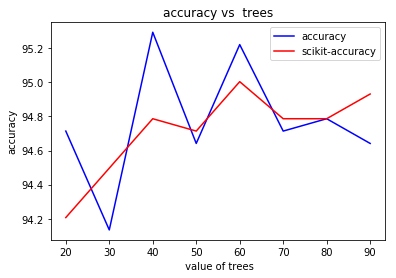

Average time to execute scikit learn algo is  0.2474014163017273
Average time to execute own algo is  27.15326488018036


In [16]:
if __name__ == "__main__":
    random_forest()